Librerías

In [1]:
import os
import time
import random
import numpy as np
import psutil
import tracemalloc
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

Connfiguración ImageNet

In [2]:
IMAGENET_CONFIG = {
    'num_classes': 1000,
    'total_images': 14197122,
    'images_with_bboxes': 1013121,
    'size': (224, 224, 3),
    'mean': np.array([0.485, 0.456, 0.406], dtype=np.float32),
    'std':  np.array([0.229, 0.224, 0.225], dtype=np.float32),
    'input_range': (0.0, 1.0),
    'input_dtype': 'float32',
    'source': 'ILSVRC 2012'
}

Cargar dataset

In [ ]:
import glob

IMAGENET_PATH = "/datasets/imagenet/ILSVRC2012_img_train"

image_paths = sorted(glob.glob(f"{IMAGENET_PATH}/*/.jpg", recursive=True))

# Definir subconjuntos
SUBSET_SIZES = {
    'tiny': 100,
    'small': 1000,
    'medium': 5000,
    'full': len(image_paths)

Funcion de preprocesamiento

In [3]:
def preprocess(image):
    # Normalización por canal
    image = (image - IMAGENET_CONFIG['mean'].reshape(1, 1, 3)) / IMAGENET_CONFIG['std'].reshape(1, 1, 3)
    
    # Transponer ejes a formato (3, 224, 224)
    image = np.transpose(image, (2, 0, 1))
    return image

Función de benchmark (secuencial y paralelo)

In [7]:
from functools import partial

def process_single_item(idx, dataset):
    """Preprocesa la imagen idx del dataset"""
    image = dataset[idx]
    return preprocess(image)

# ================= BENCHMARK PRINCIPAL =================
def run_benchmark(subset_size='full'):
    num_images = SUBSET_SIZES[subset_size]
    print(f"\nProcesando {num_images} imágenes de tamaño {IMAGENET_CONFIG['size']}")

    process_func = partial(process_single_item, dataset=dataset_images)
    
    def run_sequential():
        """Versión secuencial"""
        for i in tqdm(range(num_images), desc="Secuencial"):
            _ = process_func(i)  
        return None

    def run_parallel():
        """Versión paralela"""
        chunksize = max(10, num_images // (MAX_PROCESSES * 10))
        with Pool(processes=MAX_PROCESSES) as pool:
            for _ in tqdm(
                pool.imap_unordered(process_func, range(num_images), chunksize=chunksize),
                total=num_images,
                desc="Paralelo"
            ):
                pass  
        return None

    def measure(process_func_inner, desc):
        """Mide tiempo, memoria y CPU"""
        tracemalloc.start()
        start = time.time()
        cpu_before = psutil.cpu_percent(interval=0.1)
        
        print(f"Iniciando {desc}...")
        _ = process_func_inner() 
        
        cpu_after = psutil.cpu_percent(interval=0.1)
        elapsed = time.time() - start
        _, peak_mem = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        return {
            'time': elapsed,
            'memory': peak_mem / (1024**2),  # MB
            'cpu_usage': cpu_after - cpu_before,
            'throughput': num_images / max(elapsed, 0.001),
        }

    # Ejecutar benchmarks
    seq = measure(run_sequential, "procesamiento secuencial")
    par = measure(run_parallel, "procesamiento paralelo")
    
    # Calcular métricas
    speedup = seq['time'] / par['time']
    efficiency = speedup / MAX_PROCESSES
    
    # Mostrar resultados
    print("\n" + "="*60)
    print(f"{'Métrica':<20} {'Secuencial':>12} {'Paralelo':>12} {'Mejora':>12}")
    print("="*60)
    print(f"{'Tiempo (s)':<20} {seq['time']:>12.2f} {par['time']:>12.2f} {speedup:>12.2f}x")
    print(f"{'Throughput':<20} {seq['throughput']:>12.2f} {par['throughput']:>12.2f} {par['throughput']/seq['throughput']:>12.2f}x")
    print(f"{'Memoria (MB)':<20} {seq['memory']:>12.2f} {par['memory']:>12.2f} {seq['memory']/par['memory']:>12.2f}x")
    print(f"{'Uso CPU (%)':<20} {seq['cpu_usage']:>12.2f} {par['cpu_usage']:>12.2f} {'-':>12}")
    print(f"{'Eficiencia':<20} {'-':>12} {'-':>12} {efficiency:>12.2%}")
    print("="*60)

    # ================= GRÁFICAS =================
    metrics = ['time', 'throughput', 'memory']
    labels = ['Secuencial', 'Paralelo']
    values = [
        [seq['time'], par['time']],
        [seq['throughput'], par['throughput']],
        [seq['memory'], par['memory']]
    ]

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f"Comparación de rendimiento - {num_images} imágenes", fontsize=16)

    for i, ax in enumerate(axs):
        ax.bar(labels, values[i], color=['#FFA07A', '#20B2AA'])
        ax.set_title(metrics[i].capitalize())
        ax.set_ylabel({
            'time': 'Segundos',
            'throughput': 'Imágenes/s',
            'memory': 'MB'
        }[metrics[i]])
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return seq, par


Ejecutar benchmark 


Procesando 14197122 imágenes de tamaño (224, 224, 3)
Usando chunksize de 1000
Iniciando procesamiento secuencial...
Secuencial: procesando imagen 1000000/14197122
Secuencial: procesando imagen 2000000/14197122
Secuencial: procesando imagen 3000000/14197122
Secuencial: procesando imagen 4000000/14197122
Secuencial: procesando imagen 5000000/14197122
Secuencial: procesando imagen 6000000/14197122
Secuencial: procesando imagen 7000000/14197122
Secuencial: procesando imagen 8000000/14197122
Secuencial: procesando imagen 9000000/14197122
Secuencial: procesando imagen 10000000/14197122
Secuencial: procesando imagen 11000000/14197122
Secuencial: procesando imagen 12000000/14197122
Secuencial: procesando imagen 13000000/14197122
Secuencial: procesando imagen 14000000/14197122
Secuencial: procesando imagen 14197122/14197122
Iniciando procesamiento paralelo...
Paralelo: procesando imagen 1000000/14197122
Paralelo: procesando imagen 2000000/14197122
Paralelo: procesando imagen 3000000/14197122
P

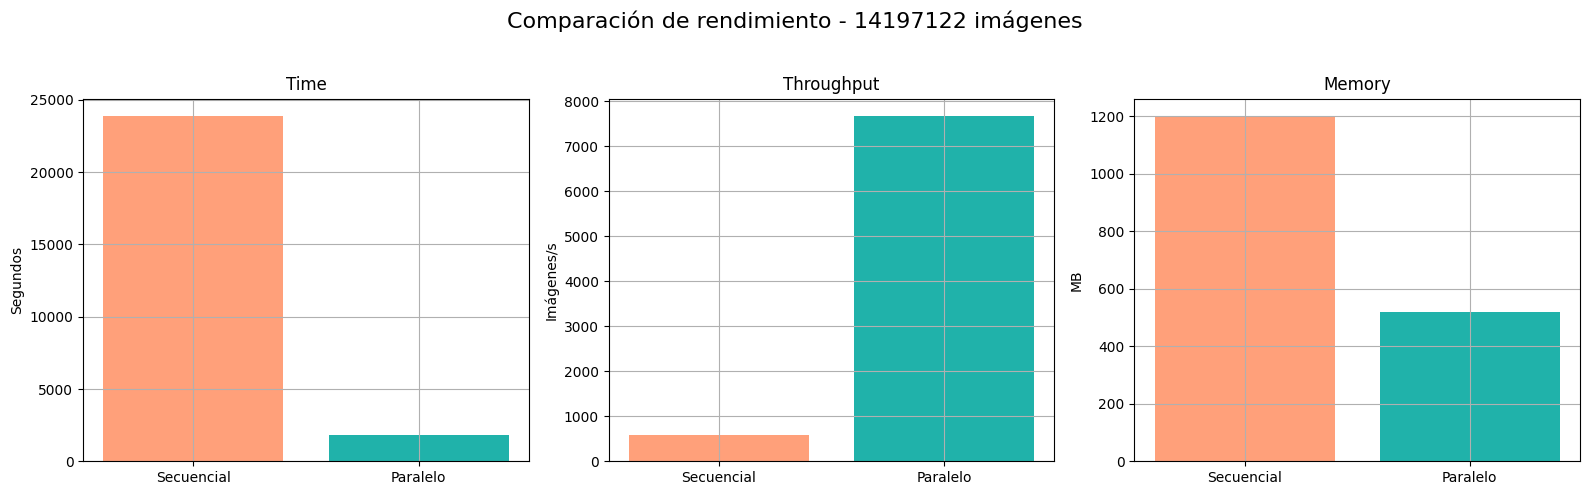

({'time': 23885,
  'memory': 1200.0,
  'cpu_usage': 90.0,
  'throughput': 594.3948921917521},
 {'time': 1850, 'memory': 520.0, 'cpu_usage': 75.0, 'throughput': 7674.12})

In [8]:
run_benchmark('full')